In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

class EWC:
    def __init__(self, model, dataloader, importance=10):
        self.model = model
        self.dataloader = dataloader
        self.importance = importance
        self.initial_params = {n: p.clone() for n, p in self.model.named_parameters()}
        self.fisher_diagonal = self.compute_fisher_information()


    def compute_fisher_information(self):
         fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
         self.model.eval()
    
         for i, (data, target, task_id) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
        
            # Pass both `data` and `task_id` to the model
            output = self.model(data, task_id)
        
            # Use the target for the loss
            loss = F.mse_loss(output, target)
            loss.backward()
        
            # Fisher information accumulation
            for n, p in self.model.named_parameters():
                grad_squared = p.grad ** 2
                fisher_diagonal[n] = fisher_diagonal[n] + (grad_squared - fisher_diagonal[n]) / i
        
         return fisher_diagonal

    def penalty(self):
        penalty = 0
        for n, p in self.model.named_parameters():
            penalty += (self.fisher_diagonal[n] * (p - self.initial_params[n]) ** 2).sum()
        return self.importance * penalty


In [14]:
import torch.nn.functional as F
import torch.nn as nn

class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=10, shared_dim=10, output_dim_A=1, output_dim_B=1):
        super(SimpleNeuralNet, self).__init__()
        # Shared hidden layers
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)  # Input dimension includes task identifier
        self.fc2 = nn.Linear(hidden_dim, shared_dim)
        
        # Task-specific output layers
        self.fc3_A = nn.Linear(shared_dim, output_dim_A)
        self.fc3_B = nn.Linear(shared_dim, output_dim_B)

    def forward(self, x, task_id):
        # Ensure task_id has shape (batch_size, 1) and concatenate it with x
        task_id = task_id.view(-1, 1)  # Make sure task_id has shape [batch_size, 1]
        x = torch.cat((x, task_id), dim=1)  # Concatenate input with task_id along feature dimension
        
        # Shared forward path
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Task-specific outputs
        output_A = self.fc3_A(x)
        output_B = self.fc3_B(x)

        # Select appropriate output based on task_id
        output = torch.zeros(x.size(0), max(output_A.size(1), output_B.size(1)), device=x.device)
        output[:, :output_A.size(1)] = output_A * (task_id == 1).float()
        output[:, :output_B.size(1)] += output_B * (task_id == 0).float()

        return output


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch

# Generate sine wave data
def generate_sine_data(phase_shift=0, num_samples=60000):
    x = np.linspace(0, 2 * np.pi, num_samples)
    y = np.sin(x + phase_shift)
    return x, y

# Task A: Sine wave without phase shift
x_A, y_A = generate_sine_data(phase_shift=0)

# Task B: Sine wave with a quarter phase shift
x_B, y_B = generate_sine_data(phase_shift=np.pi / 2)

# Convert to tensors
x_A_tensor = torch.tensor(x_A, dtype=torch.float32).unsqueeze(1)  # Shape (num_samples, 1)
y_A_tensor = torch.tensor(y_A, dtype=torch.float32).unsqueeze(1)

x_B_tensor = torch.tensor(x_B, dtype=torch.float32).unsqueeze(1)
y_B_tensor = torch.tensor(y_B, dtype=torch.float32).unsqueeze(1)

# Split into train, validation, and test sets for Domain A
x_A_train_val, x_A_test, y_A_train_val, y_A_test = train_test_split(
    x_A_tensor, y_A_tensor, test_size=0.2, random_state=42
)
x_A_train, x_A_val, y_A_train, y_A_val = train_test_split(
    x_A_train_val, y_A_train_val, test_size=0.25, random_state=42
)

# Split into train, validation, and test sets for Domain B
x_B_train_val, x_B_test, y_B_train_val, y_B_test = train_test_split(
    x_B_tensor, y_B_tensor, test_size=0.2, random_state=42
)
x_B_train, x_B_val, y_B_train, y_B_val = train_test_split(
    x_B_train_val, y_B_train_val, test_size=0.25, random_state=42
)

# Create base datasets without task identifier
train_dataset_A = TensorDataset(x_A_train, y_A_train)
val_dataset_A = TensorDataset(x_A_val, y_A_val)
test_dataset_A = TensorDataset(x_A_test, y_A_test)

train_dataset_B = TensorDataset(x_B_train, y_B_train)
val_dataset_B = TensorDataset(x_B_val, y_B_val)
test_dataset_B = TensorDataset(x_B_test, y_B_test)

# Wrap datasets with TaskIdentifierDataset to include task_id
class TaskIdentifierDataset(Dataset):
    def __init__(self, dataset, task_id):
        self.dataset = dataset
        self.task_id = task_id

    def __getitem__(self, index):
        data, target = self.dataset[index]
        task_identifier = torch.tensor([self.task_id], dtype=torch.float32)
        return data, target, task_identifier

    def __len__(self):
        return len(self.dataset)

# Apply task identifiers (1 for Task A, 0 for Task B)
train_dataset_A_with_id = TaskIdentifierDataset(train_dataset_A, task_id=1)
val_dataset_A_with_id = TaskIdentifierDataset(val_dataset_A, task_id=1)
test_dataset_A_with_id = TaskIdentifierDataset(test_dataset_A, task_id=1)

train_dataset_B_with_id = TaskIdentifierDataset(train_dataset_B, task_id=0)
val_dataset_B_with_id = TaskIdentifierDataset(val_dataset_B, task_id=0)
test_dataset_B_with_id = TaskIdentifierDataset(test_dataset_B, task_id=0)

# Create data loaders
batch_size = 64
train_loader_A = DataLoader(train_dataset_A_with_id, batch_size=batch_size, shuffle=True)
val_loader_A = DataLoader(val_dataset_A_with_id, batch_size=batch_size, shuffle=False)
test_loader_A = DataLoader(test_dataset_A_with_id, batch_size=batch_size, shuffle=False)

train_loader_B = DataLoader(train_dataset_B_with_id, batch_size=batch_size, shuffle=True)
val_loader_B = DataLoader(val_dataset_B_with_id, batch_size=batch_size, shuffle=False)
test_loader_B = DataLoader(test_dataset_B_with_id, batch_size=batch_size, shuffle=False)


In [16]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_mse = 0
    total_mae = 0
    with torch.no_grad():
        for data, target, task_id in loader:  # Include task_id here
            output = model(data,task_id)
            loss = criterion(output, target)
            total_loss += loss.item()
            total_mse += F.mse_loss(output, target).item()
            total_mae += F.l1_loss(output, target).item()
    return {
        'loss': total_loss / len(loader),
        'mse': total_mse / len(loader),
        'mae': total_mae / len(loader)
    }

In [17]:
class SynapticIntelligence:
    def __init__(self, model, dataloader, importance=500):
        self.model = model
        self.dataloader = dataloader
        self.importance = importance
        self.init_params = {n: p.clone() for n, p in self.model.named_parameters()}
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
        self.compute_omega()

    def compute_omega(self):
        self.model.eval()
        for data, target,task_id in self.dataloader:
            self.model.zero_grad()
            output = self.model(data,task_id)
            loss = F.mse_loss(output, target)
            loss.backward()
            for n, p in self.model.named_parameters():
                self.omega[n] += p.grad.abs() / (p - self.init_params[n]).abs().clamp(min=1e-8)
        for n in self.omega:
            self.omega[n] /= len(self.dataloader)

    def penalty(self):
        penalty = 0
        for n, p in self.model.named_parameters():
            penalty += (self.omega[n] * (p - self.init_params[n]).pow(2)).sum()
        return self.importance * penalty

def train_with_si(model, loader, optimizer, criterion, si, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0
        for data, target,task_id in loader:
            optimizer.zero_grad()
            output = model(data,task_id)
            loss = criterion(output, target)
            penalty = si.penalty().detach()  # Detach the penalty from the graph
            total_loss += loss.item()
            total_penalty += penalty.item()
            loss += penalty
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader)}, Penalty: {total_penalty / len(loader)}')


In [18]:
def train_with_si(model, loader, si, optimizer, criterion, epochs=50):
    """
    Train the model with Synaptic Intelligence (SI) regularization.
    Args:
        model: Neural network model to train.
        loader: DataLoader for the current task.
        si: Instance of SynapticIntelligenceOnline, or None for the first task.
        optimizer: Optimizer for training.
        criterion: Loss function (MSE for regression).
        epochs: Number of training epochs.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0

        for data, target, task_id in loader:
            optimizer.zero_grad()
            output = model(data, task_id)
            loss = criterion(output, target)

            # Add SI penalty if applicable
            penalty = si.penalty() if si is not None else 0
            total_loss += loss.item()
            total_penalty += penalty.item() if si is not None else 0
            loss += penalty

            # Backward and optimizer step
            loss.backward()
            optimizer.step()

            # Update omega if SI is active
            if si is not None:
                si.update_omega(loss, optimizer.param_groups[0]['lr'])

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}, Penalty: {total_penalty / len(loader):.4f}')
    
    # Normalize omega after training on the task
    if si is not None:
        si.normalize_omega(len(loader.dataset))


import logging

# Configure logging
logging.basicConfig(
    filename="si_debug.log",  # Save logs to a file
    level=logging.INFO,  # Set the level of details
    format="%(asctime)s - %(message)s"
)

class SynapticIntelligenceOnline:
    def __init__(self, model, dataloader):
        """
        Synaptic Intelligence (SI) implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.omega = {}
        self.optimal_params = {}

        # Initialize omega and optimal_params
        self._initialize_params()

    def _initialize_params(self):
        """
        Initialize or reset omega and optimal_params to match the current model's parameters.
        """
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def update_omega(self):
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        dataset_size = len(self.dataloader.dataset)  # Normalize by dataset size
        for i, (data, target,task_id) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data,task_id)
            loss = F.mse_loss(output, target)  # Use MSE loss for regression
            loss.backward()
            
            # Accumulate squared gradients
            for n, p in self.model.named_parameters():
                if p.grad is not None and p.requires_grad:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
    
        # Normalize and update Omega
        for n in fisher_diagonal:
            if n in self.omega:
                self.omega[n] += fisher_diagonal[n] / dataset_size  # Normalize by dataset size
            else:
                self.omega[n] = fisher_diagonal[n] / dataset_size
    
        # Log Omega stats
        omega_stats = {n: (self.omega[n].max().item(), self.omega[n].min().item()) for n in self.omega}
        logging.info(f"Updated Omega stats: {omega_stats}")


    def store_optimal_params(self):
        """
        Store the current model parameters as the optimal parameters after training a task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        penalty = 0.0
        for n, p in model.named_parameters():
            if n in self.omega and n in self.optimal_params:
                diff = p - self.optimal_params[n]
                term = (self.omega[n] * diff ** 2).sum()
                penalty += term
        # Log penalty details
        logging.info(f"Penalty computed: {penalty}")
        return penalty


def train_with_si(model, optimizer, dataloaders, si=None, lambda_si=0.1, epochs=5):
    """
    Train the model with or without SI penalty.

    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        si: Instance of the SynapticIntelligence class, or None if not using SI.
        lambda_si: Importance of the SI penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets,task_id in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs,task_id)
            loss = criterion(outputs, targets)

            # Add SI penalty if applicable
            if si is not None:
                si_penalty = si.penalty(model)
                loss += lambda_si * si_penalty
                total_penalty += si_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log losses
        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")





In [19]:
def train_with_rehearsal(model, current_loader, previous_loader, optimizer, criterion, epochs=50, replay_ratio=0.5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target,task_id in current_loader:
            optimizer.zero_grad()
            output = model(data,task_id)
            loss = criterion(output, target)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        # Mixing with previous task data
        for prev_data, prev_target,prev_task_id in previous_loader:
            optimizer.zero_grad()
            prev_output = model(prev_data,prev_task_id)
            prev_loss = criterion(prev_output, prev_target) * replay_ratio
            total_loss += prev_loss.item()
            prev_loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(current_loader)}')


In [20]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

class ProgressiveNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, output_dim=1):
        super(ProgressiveNN, self).__init__()

        # Task-specific layers for Task A
        self.task0_fc1 = nn.Linear(input_dim, hidden_dim)
        self.task0_fc2 = nn.Linear(hidden_dim, output_dim)

        # Task-specific layers for Task B
        self.task1_fc1 = nn.Linear(input_dim, hidden_dim)
        self.task1_fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, task_id):
        # Creating masks to select data points belonging to each task
        task0_mask = (task_id == 0).float().view(-1, 1)  # Task A mask
        task1_mask = (task_id == 1).float().view(-1, 1)  # Task B mask

        # Task A forward pass
        x_task0 = F.relu(self.task0_fc1(x))
        output_task0 = self.task0_fc2(x_task0)

        # Task B forward pass
        x_task1 = F.relu(self.task1_fc1(x))
        output_task1 = self.task1_fc2(x_task1)

        # Combining the outputs using the task masks
        output = output_task0 * task0_mask + output_task1 * task1_mask
        return output



# Define the training function for ProgressiveNN
# Updated training function for ProgressiveNN with gradient logging and higher learning rate
def train_prognn(model, loader, optimizer, criterion, task_num, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target,task_id in loader:
            if data.shape[1] != 128:
                data = data.repeat(1, 128)  # Ensure shape is [batch_size, 128]
            optimizer.zero_grad()            
            output = model(data, task_id)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}')



def evaluate_prognn(model, loader, criterion, task_num):
    model.eval()
    total_loss = 0
    total_mse = 0
    total_mae = 0
    with torch.no_grad():
        for data, target,task_id in loader:
            if data.shape[1] != 128:
                data = data.repeat(1, 128)  # Expands the data to shape [batch_size, 128]
            output = model(data, task_id)
            loss = criterion(output, target)
            total_loss += loss.item()
            total_mse += F.mse_loss(output, target).item()
            total_mae += F.l1_loss(output, target).item()
    return {
        'loss': total_loss / len(loader),
        'mse': total_mse / len(loader),
        'mae': total_mae / len(loader)
    }


In [287]:
epoch_stats_other = {
    "si": {"acc_B": [], "loss_B": [], "task_A_during_B":[],"task_A_during_B_loss":[],"val_task_A_during_B":[],"val_acc_B":[],"B_during_A":[],"A_during_A":[],"B_during_A_val":[],"A_during_A_val":[]},
    "pnn": {"acc_B": [], "loss_B": [], "task_A_during_B":[],"task_A_during_B_loss":[],"val_task_A_during_B":[],"val_acc_B":[],"B_during_A":[],"A_during_A":[],"B_during_A_val":[],"A_during_A_val":[]},
    "reh": {"acc_B": [], "loss_B": [], "task_A_during_B":[],"task_A_during_B_loss":[],"val_task_A_during_B":[],"val_acc_B":[],"B_during_A":[],"A_during_A":[],"B_during_A_val":[],"A_during_A_val":[]}
}

In [183]:
epochs = 50
num_runs = 1

In [34]:
for key in epoch_stats_other["si"]:
    epoch_stats_other["si"][key] = []

In [401]:
epoch_stats_other_B = epoch_stats_other

In [35]:
epochs = 100
num_runs = 10

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Synaptic Intelligence
    model_si = SimpleNeuralNet()
    optimizer_si = optim.Adam(model_si.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    si = SynapticIntelligenceOnline(model_si,train_loader_A)
    model_si.load_state_dict(torch.load('til_toy_task_A_model.pth'))
    
        
    task_B_during_A_si_run = []
    task_A_during_A_si_run = []

    task_B_during_A_si_run_val = []
    task_A_during_A_si_run_val = []
    
    # Train on Domain A and compute SI
    
    # for epoch in range(epochs):
    #     train_with_si(model_si, train_loader_A, si=None, optimizer = optimizer_si, criterion = criterion, epochs=1) 
    
    #     # Evaluate initial performance on Domain A (test and validation)
    #     metrics_domainA_initial_si_test = evaluate(model_si, test_loader_A, criterion)
    #     metrics_domainA_initial_si_val = evaluate(model_si, val_loader_A, criterion)
    #     print(f"Domain A - Initial with SI (Test): {metrics_domainA_initial_si_test}")
    #     print(f"Domain A - Initial with SI (Validation): {metrics_domainA_initial_si_val}")
    #     task_A_during_A_si_run.append(metrics_domainA_initial_si_test['mae'])
    #     task_A_during_A_si_run_val.append(metrics_domainA_initial_si_val['mae'])

        
    #     # Evaluate initial performance on Domain A (test and validation)
    #     metrics_domainB_initial_si_test = evaluate(model_si, test_loader_B, criterion)
    #     metrics_domainB_initial_si_val = evaluate(model_si, val_loader_B, criterion)
    #     print(f"Domain B - Initial with SI (Test): {metrics_domainB_initial_si_test}")
    #     print(f"Domain B - Initial with SI (Validation): {metrics_domainB_initial_si_val}")
    #     task_B_during_A_si_run.append(metrics_domainB_initial_si_test['mae'])
    #     task_B_during_A_si_run_val.append(metrics_domainB_initial_si_val['mae'])

    # epoch_stats_other["si"]["B_during_A"].append(task_B_during_A_si_run)
    # epoch_stats_other["si"]["A_during_A"].append(task_A_during_A_si_run)

    # epoch_stats_other["si"]["B_during_A_val"].append(task_B_during_A_si_run_val)
    # epoch_stats_other["si"]["A_during_A_val"].append(task_A_during_A_si_run_val)

    metrics_domainA_initial_si_test = evaluate(model_si, test_loader_A, criterion)
    metrics_domainA_initial_si_val = evaluate(model_si, val_loader_A, criterion)
    print(f"Domain A - Initial with SI (Test): {metrics_domainA_initial_si_test}")
    print(f"Domain A - Initial with SI (Validation): {metrics_domainA_initial_si_val}")

    task_A_during_B_si_run = []
    task_B_si_run = []
    val_A_during_B_si_run = []
    val_B_si_run = []
    
    si.update_omega()
    si.store_optimal_params()
    # Train on Domain B with SI
    for epoch in range(epochs):
        #train_with_si(model_si, train_loader_B, si=si, optimizer = optimizer_si, criterion = criterion, epochs=1)
        train_with_si(model_si, optimizer_si, {'train': train_loader_B, 'val': val_loader_B}, si=si, lambda_si=500000000000, epochs=1)
        
        # Evaluate on test set for Domain B
        si_B_metrics = evaluate(model_si, test_loader_B, criterion)
        epoch_stats_other["si"]["loss_B"].append(si_B_metrics['loss'])
        task_B_si_run.append(si_B_metrics['mae'])

        # Evaluate on validation set for Domain B
        si_B_val_metrics = evaluate(model_si, val_loader_B, criterion)
        val_B_si_run.append(si_B_val_metrics['mae'])

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        si_performance_A_during_B = evaluate(model_si, test_loader_A, criterion)
        epoch_stats_other["si"]["task_A_during_B_loss"].append(si_performance_A_during_B['loss'])
        task_A_during_B_si_run.append(si_performance_A_during_B['mae'])

        si_performance_A_during_B_val = evaluate(model_si, val_loader_A, criterion)
        val_A_during_B_si_run.append(si_performance_A_during_B_val['mae'])

    epoch_stats_other["si"]["task_A_during_B"].append(task_A_during_B_si_run)
    epoch_stats_other["si"]["acc_B"].append(task_B_si_run)

    # Store validation metrics for each run
    epoch_stats_other["si"]["val_task_A_during_B"].append(val_A_during_B_si_run)
    epoch_stats_other["si"]["val_acc_B"].append(val_B_si_run)

    # Evaluate final performance on Domain B with SI
    metrics_domainB_si_test = evaluate(model_si, test_loader_B, criterion)
    metrics_domainB_si_val = evaluate(model_si, val_loader_B, criterion)
    print(f"Domain B with SI (Test): {metrics_domainB_si_test}")
    print(f"Domain B with SI (Validation): {metrics_domainB_si_val}")

    # Evaluate final performance on Domain A after Domain B with SI
    metrics_domainA_after_B_si_test = evaluate(model_si, test_loader_A, criterion)
    metrics_domainA_after_B_si_val = evaluate(model_si, val_loader_A, criterion)
    print(f"Domain A after Domain B with SI (Test): {metrics_domainA_after_B_si_test}")
    print(f"Domain A after Domain B with SI (Validation): {metrics_domainA_after_B_si_val}")


Run 1/10


C:\Users\gslax\AppData\Local\Temp\ipykernel_21760\2786348114.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_si.load_state_dict(torch.load('til_toy_task_A_model.p

Domain A - Initial with SI (Test): {'loss': 8.704932108540039e-05, 'mse': 8.704932108540039e-05, 'mae': 0.007291342391870282}
Domain A - Initial with SI (Validation): {'loss': 8.94507232434525e-05, 'mse': 8.94507232434525e-05, 'mae': 0.007362188157090482}
Epoch 1/1, Loss: 0.4934, Penalty: 0.0000
Epoch 1/1, Loss: 0.4247, Penalty: 0.0000
Epoch 1/1, Loss: 0.3646, Penalty: 0.0000
Epoch 1/1, Loss: 0.3064, Penalty: 0.0000
Epoch 1/1, Loss: 0.2517, Penalty: 0.0000
Epoch 1/1, Loss: 0.2025, Penalty: 0.0000
Epoch 1/1, Loss: 0.1588, Penalty: 0.0000
Epoch 1/1, Loss: 0.1209, Penalty: 0.0000
Epoch 1/1, Loss: 0.0892, Penalty: 0.0000
Epoch 1/1, Loss: 0.0641, Penalty: 0.0000
Epoch 1/1, Loss: 0.0452, Penalty: 0.0000
Epoch 1/1, Loss: 0.0314, Penalty: 0.0000
Epoch 1/1, Loss: 0.0218, Penalty: 0.0000
Epoch 1/1, Loss: 0.0150, Penalty: 0.0000
Epoch 1/1, Loss: 0.0103, Penalty: 0.0000
Epoch 1/1, Loss: 0.0072, Penalty: 0.0000
Epoch 1/1, Loss: 0.0052, Penalty: 0.0000
Epoch 1/1, Loss: 0.0041, Penalty: 0.0000
Epoch 

In [395]:
for key in epoch_stats_other["si"]:
    epoch_stats_other["si"][key] = []

In [1]:
epoch_stats_other["si"]["task_A_during_B"]

NameError: name 'epoch_stats_other' is not defined

In [369]:
num_runs = 9
epochs = 100
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Data Rehearsal
    model_rehearsal = SimpleNeuralNet()
    optimizer_rehearsal = optim.Adam(model_rehearsal.parameters(), lr=0.0001)
    
    task_B_during_A_reh_run = []
    task_A_during_A_reh_run = []

    task_B_during_A_reh_run_val = []
    task_A_during_A_reh_run_val = []
    
    # Train on Domain A with rehearsal
    for epoch in range(epochs):
        train(model_rehearsal, train_loader_A, optimizer_rehearsal, criterion, epochs=1)
    
        # Evaluate initial performance on Domain A (test and validation)
        metrics_domainA_initial_rehearsal_test = evaluate(model_rehearsal, test_loader_A, criterion)
        metrics_domainA_initial_rehearsal_val = evaluate(model_rehearsal, val_loader_A, criterion)
        print(f"Domain A - Initial with Rehearsal (Test): {metrics_domainA_initial_rehearsal_test}")
        print(f"Domain A - Initial with Rehearsal (Validation): {metrics_domainA_initial_rehearsal_val}")
        task_A_during_A_reh_run.append(metrics_domainA_initial_rehearsal_test['mae'])
        task_A_during_A_reh_run_val.append(metrics_domainA_initial_rehearsal_val['mae'])
        

        # Evaluate initial performance on Domain A (test and validation)
        metrics_domainB_initial_rehearsal_test = evaluate(model_rehearsal, test_loader_B, criterion)
        metrics_domainB_initial_rehearsal_val = evaluate(model_rehearsal, val_loader_B, criterion)
        print(f"Domain B - Initial with Rehearsal (Test): {metrics_domainB_initial_rehearsal_test}")
        print(f"Domain B - Initial with Rehearsal (Validation): {metrics_domainB_initial_rehearsal_val}")
        task_B_during_A_reh_run.append(metrics_domainB_initial_rehearsal_test['mae'])
        task_B_during_A_reh_run_val.append(metrics_domainB_initial_rehearsal_val['mae'])
    
    epoch_stats_other["reh"]["B_during_A"].append(task_B_during_A_reh_run)
    epoch_stats_other["reh"]["A_during_A"].append(task_A_during_A_reh_run)

    epoch_stats_other["reh"]["B_during_A_val"].append(task_B_during_A_reh_run_val)
    epoch_stats_other["reh"]["A_during_A_val"].append(task_A_during_A_reh_run_val)
    
    task_A_during_B_reh_run = []
    task_B_reh_run = []
    val_A_during_B_reh_run = []
    val_B_reh_run = []

    # Train on Domain B with rehearsal
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_B, train_loader_A, optimizer_rehearsal, criterion, epochs=1, replay_ratio=0.6)
    
        # Evaluate on test set for Domain B
        reh_B_metrics = evaluate(model_rehearsal, test_loader_B, criterion)
        epoch_stats_other["reh"]["loss_B"].append(reh_B_metrics['loss'])
        task_B_reh_run.append(reh_B_metrics['mae'])
        
        # Evaluate on validation set for Domain B
        reh_B_val_metrics = evaluate(model_rehearsal, val_loader_B, criterion)
        val_B_reh_run.append(reh_B_val_metrics['mae'])

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        reh_performance_A_during_B = evaluate(model_rehearsal, test_loader_A, criterion)
        epoch_stats_other["reh"]["task_A_during_B_loss"].append(reh_performance_A_during_B['loss'])
        task_A_during_B_reh_run.append(reh_performance_A_during_B['mae'])

        reh_performance_A_during_B_val = evaluate(model_rehearsal, val_loader_A, criterion)
        val_A_during_B_reh_run.append(reh_performance_A_during_B_val['mae'])

    epoch_stats_other["reh"]["task_A_during_B"].append(task_A_during_B_reh_run)
    epoch_stats_other["reh"]["acc_B"].append(task_B_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_task_A_during_B"].append(val_A_during_B_reh_run)
    epoch_stats_other["reh"]["val_acc_B"].append(val_B_reh_run)
    
    # Evaluate performance on Domain B with rehearsal (test and validation)
    metrics_domainB_rehearsal_test = evaluate(model_rehearsal, test_loader_B, criterion)
    metrics_domainB_rehearsal_val = evaluate(model_rehearsal, val_loader_B, criterion)
    print(f"Domain B with Rehearsal (Test): {metrics_domainB_rehearsal_test}")
    print(f"Domain B with Rehearsal (Validation): {metrics_domainB_rehearsal_val}")
    
    # Evaluate performance on Domain A after Domain B with rehearsal (test and validation)
    metrics_domainA_after_B_rehearsal_test = evaluate(model_rehearsal, test_loader_A, criterion)
    metrics_domainA_after_B_rehearsal_val = evaluate(model_rehearsal, val_loader_A, criterion)
    print(f"Domain A after Domain B with Rehearsal (Test): {metrics_domainA_after_B_rehearsal_test}")
    print(f"Domain A after Domain B with Rehearsal (Validation): {metrics_domainA_after_B_rehearsal_val}")


Run 1/9
Epoch 1/1, Loss: 0.6474, MAE: 0.6804
Domain A - Initial with Rehearsal (Test): {'loss': 0.5529136518214611, 'mse': 0.5529136518214611, 'mae': 0.6398440307759224}
Domain A - Initial with Rehearsal (Validation): {'loss': 0.5614301186609776, 'mse': 0.5614301186609776, 'mae': 0.6472793735088186}
Domain B - Initial with Rehearsal (Test): {'loss': 3.0811251021446067, 'mse': 3.0811251021446067, 'mae': 1.564012368308737}
Domain B - Initial with Rehearsal (Validation): {'loss': 3.046513458515735, 'mse': 3.046513458515735, 'mae': 1.552347126159262}
Epoch 1/1, Loss: 0.4787, MAE: 0.5975
Domain A - Initial with Rehearsal (Test): {'loss': 0.4036885674329514, 'mse': 0.4036885674329514, 'mae': 0.5510474196139802}
Domain A - Initial with Rehearsal (Validation): {'loss': 0.40977176833660045, 'mse': 0.40977176833660045, 'mae': 0.557688812943215}
Domain B - Initial with Rehearsal (Test): {'loss': 3.749301342253989, 'mse': 3.749301342253989, 'mae': 1.7283942528227543}
Domain B - Initial with Rehear

In [195]:

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Progressive Neural Networks
    model_prognn = ProgressiveNN(input_dim=128, hidden_dim=128, output_dim=1)
    optimizer_prognn = optim.Adam(model_prognn.parameters(), lr=0.0001)

    # Add new task for Domain B
    #model_prognn.add_new_task(1, 1)

    task_B_during_A_pnn_run = []
    task_A_during_A_pnn_run = []

    task_B_during_A_pnn_run_val = []
    task_A_during_A_pnn_run_val = []
    
    # Train on Domain A
    for epoch in range(epochs):
        train_prognn(model_prognn, train_loader_A, optimizer_prognn, criterion, task_num=0, epochs=1)
    
        # Evaluate initial performance on Domain A (test and validation)
        metrics_domainA_initial_prognn_test = evaluate_prognn(model_prognn, test_loader_A, criterion,task_num=0)
        metrics_domainA_initial_prognn_val = evaluate_prognn(model_prognn, val_loader_A, criterion,task_num=0)
        print(f"Domain A - Initial with ProgNN (Test): {metrics_domainA_initial_prognn_test}")
        print(f"Domain A - Initial with ProgNN (Validation): {metrics_domainA_initial_prognn_val}")
        task_A_during_A_pnn_run.append(metrics_domainA_initial_prognn_test['mae'])
        task_A_during_A_pnn_run_val.append(metrics_domainA_initial_prognn_val['mae'])

        # Evaluate initial performance on Domain A (test and validation)
        metrics_domainB_initial_prognn_test = evaluate_prognn(model_prognn, test_loader_B, criterion,task_num=1)
        metrics_domainB_initial_prognn_val = evaluate_prognn(model_prognn, val_loader_B, criterion,task_num=1)
        print(f"Domain A - Initial with ProgNN (Test): {metrics_domainB_initial_prognn_test}")
        print(f"Domain A - Initial with ProgNN (Validation): {metrics_domainB_initial_prognn_val}")
        task_B_during_A_pnn_run.append(metrics_domainB_initial_prognn_test['mae'])
        task_B_during_A_pnn_run_val.append(metrics_domainB_initial_prognn_val['mae'])
    

    epoch_stats_other["pnn"]["B_during_A"].append(task_B_during_A_pnn_run)
    epoch_stats_other["pnn"]["A_during_A"].append(task_A_during_A_pnn_run)
    epoch_stats_other["pnn"]["B_during_A_val"].append(task_B_during_A_pnn_run_val)
    epoch_stats_other["pnn"]["A_during_A_val"].append(task_A_during_A_pnn_run_val)
    
    task_A_during_B_pnn_run = []
    task_B_pnn_run = []
    val_A_during_B_pnn_run = []
    val_B_pnn_run = []

    # Train on Domain B with ProgNN
    for epoch in range(epochs):
        train_prognn(model_prognn, train_loader_B, optimizer_prognn, criterion, task_num=1, epochs=1)

        # Evaluate on test set for Domain B
        pnn_B_metrics = evaluate_prognn(model_prognn, test_loader_B, criterion,task_num=1)
        epoch_stats_other["pnn"]["loss_B"].append(pnn_B_metrics['loss'])
        task_B_pnn_run.append(pnn_B_metrics['mae'])

        # Evaluate on validation set for Domain B
        pnn_B_val_metrics = evaluate_prognn(model_prognn, val_loader_B, criterion,task_num=1)
        val_B_pnn_run.append(pnn_B_val_metrics['mae'])

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        pnn_performance_A_during_B = evaluate_prognn(model_prognn, test_loader_A, criterion,task_num=0)
        epoch_stats_other["pnn"]["task_A_during_B_loss"].append(pnn_performance_A_during_B['loss'])
        task_A_during_B_pnn_run.append(pnn_performance_A_during_B['mae'])

        pnn_performance_A_during_B_val = evaluate_prognn(model_prognn, val_loader_A, criterion,task_num=0)
        val_A_during_B_pnn_run.append(pnn_performance_A_during_B_val['mae'])

    epoch_stats_other["pnn"]["task_A_during_B"].append(task_A_during_B_pnn_run)
    epoch_stats_other["pnn"]["acc_B"].append(task_B_pnn_run)

    # Store validation metrics for each run
    epoch_stats_other["pnn"]["val_task_A_during_B"].append(val_A_during_B_pnn_run)
    epoch_stats_other["pnn"]["val_acc_B"].append(val_B_pnn_run)
    
    # Evaluate performance on Domain B with ProgNN (test and validation)
    metrics_domainB_prognn_test = evaluate_prognn(model_prognn, test_loader_B, criterion,task_num=1)
    metrics_domainB_prognn_val = evaluate_prognn(model_prognn, val_loader_B, criterion,task_num=1)
    print(f"Domain B with ProgNN (Test): {metrics_domainB_prognn_test}")
    print(f"Domain B with ProgNN (Validation): {metrics_domainB_prognn_val}")
    
    # Evaluate performance on Domain A after training on Domain B with ProgNN (test and validation)
    metrics_domainA_after_B_prognn_test = evaluate_prognn(model_prognn, test_loader_A, criterion,task_num=0)
    metrics_domainA_after_B_prognn_val = evaluate_prognn(model_prognn, val_loader_A, criterion,task_num=0)
    print(f"Domain A after Domain B with ProgNN (Test): {metrics_domainA_after_B_prognn_test}")
    print(f"Domain A after Domain B with ProgNN (Validation): {metrics_domainA_after_B_prognn_val}")


Run 1/10
Epoch 1/1, Loss: 0.3264
Domain A - Initial with ProgNN (Test): {'loss': 0.27425636636449935, 'mse': 0.27425636636449935, 'mae': 0.45041382772491334}
Domain A - Initial with ProgNN (Validation): {'loss': 0.27803729648919817, 'mse': 0.27803729648919817, 'mae': 0.4548236558094938}
Domain A - Initial with ProgNN (Test): {'loss': 1.7008597590821855, 'mse': 1.7008597590821855, 'mae': 1.1802779474156968}
Domain A - Initial with ProgNN (Validation): {'loss': 1.68340679939757, 'mse': 1.68340679939757, 'mae': 1.172507961379721}
Epoch 1/1, Loss: 0.2423
Domain A - Initial with ProgNN (Test): {'loss': 0.20302015273494922, 'mse': 0.20302015273494922, 'mae': 0.38879715889058214}
Domain A - Initial with ProgNN (Validation): {'loss': 0.20493356201876986, 'mse': 0.20493356201876986, 'mae': 0.3911650676993614}
Domain A - Initial with ProgNN (Test): {'loss': 1.7008597590821855, 'mse': 1.7008597590821855, 'mae': 1.1802779474156968}
Domain A - Initial with ProgNN (Validation): {'loss': 1.6834067993

In [21]:
def train(model, loader, optimizer, criterion, epochs=10):
    model.train()
    epoch_loss = []
    epoch_mae = []
    
    for epoch in range(epochs):
        total_loss = 0
        total_absolute_error = 0
        total_samples = 0
        
        for data, target,task_id in loader:
            optimizer.zero_grad()
            output = model(data,task_id)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Compute Mean Absolute Error (MAE)
            total_absolute_error += torch.sum(torch.abs(output - target)).item()
            total_samples += target.size(0)
            
        # Compute average loss and MAE for the epoch
        avg_loss = total_loss / len(loader)
        avg_mae = total_absolute_error / total_samples

        epoch_loss.append(avg_loss)
        epoch_mae.append(avg_mae)
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}')
        
    return epoch_loss, epoch_mae
    
def train_with_ewc(model, loader, optimizer, criterion, ewc, epochs):
    model.train()
    epoch_loss = []
    epoch_mae = []
    
    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0
        total_absolute_error = 0
        total_samples = 0

        for data, target,task_id in loader:
            optimizer.zero_grad()
            output = model(data,task_id)
            loss = criterion(output, target)
            penalty = ewc.penalty()
            total_loss += loss.item()
            total_penalty += penalty.item()
            loss += penalty
            loss.backward()
            optimizer.step()

            # Compute Mean Absolute Error (MAE)
            total_absolute_error += torch.sum(torch.abs(output - target)).item()
            total_samples += target.size(0)

        # Compute average loss, penalty, and MAE for the epoch
        avg_loss = total_loss / len(loader)
        avg_mae = total_absolute_error / total_samples
        avg_penalty = total_penalty / len(loader)

        epoch_loss.append(avg_loss)
        epoch_mae.append(avg_mae)

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}, MAE: {avg_mae:.4f}')

    return epoch_loss, epoch_mae


In [22]:
def evaluate_epoch(model, loader, criterion, task_num=None):
    model.eval()
    total_loss = 0
    total_mse = 0
    total_mae = 0
    with torch.no_grad():
        for data, target,task_id in loader:
            if task_num is not None:
                output = model(data, task_id)
            else:
                output = model(data,task_id)
            loss = criterion(output, target)
            total_loss += loss.item()
            total_mse += F.mse_loss(output, target).item()
            total_mae += F.l1_loss(output, target).item()
    
    return total_loss / len(loader), total_mse / len(loader), total_mae / len(loader)

In [24]:
import torch
import torch.nn as nn

def train_with_ewc(model, optimizer, dataloaders, ewc=None, lambda_ewc=0.1, epochs=5):
    """
    Train the model with EWC using Mean Squared Error (MSE) loss.

    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        ewc: Instance of the EWC class, or None if not using EWC.
        lambda_ewc: Importance of the EWC penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets, task_id in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs, task_id)
            
            # Ensure targets have the same dtype as outputs (important for MSE)
            targets = targets.to(outputs.dtype)

            loss = criterion(outputs, targets)

            # Add EWC penalty if applicable
            if ewc is not None:
                ewc_penalty = ewc.penalty(model)
                loss += lambda_ewc * ewc_penalty
                total_penalty += ewc_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log losses
        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train']) if ewc is not None else 0.0
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")


In [25]:
class OnlineEWC:
    def __init__(self, model, dataloader):
        """
        Online EWC implementation with task-aware Fisher matrices.

        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.fisher_matrix = {}  # Dictionary storing Fisher matrices per task
        self.optimal_params = {}

        # Initialize Fisher matrix and optimal parameters
        self._initialize_params()

    def _initialize_params(self):
        """
        Initialize or reset Fisher matrix and optimal_params to match the current model's parameters.
        """
        self.fisher_matrix = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def update_fisher_matrix(self):
        """
        Update the Fisher matrix using the online method.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        dataset_size = len(self.dataloader.dataset)  # Dataset size for normalization
        
        for i, (data, target, task_id) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data, task_id)

            # Calculate loss using CrossEntropyLoss
            loss = F.cross_entropy(output, target)
            loss.backward()

            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i

        # Normalize and store Fisher information
        for n in fisher_diagonal:
            if n in self.fisher_matrix:
                self.fisher_matrix[n] += fisher_diagonal[n] / max(1e-10, fisher_diagonal[n].norm().item())
            else:
                self.fisher_matrix[n] = fisher_diagonal[n] / max(1e-10, fisher_diagonal[n].norm().item())

    def store_optimal_params(self):
        """
        Store the current model parameters as the optimal parameters after training a task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Calculate the EWC penalty based on the Fisher matrix and optimal parameters.

        Args:
            model: The current model.

        Returns:
            penalty: EWC regularization term.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if n in self.fisher_matrix and n in self.optimal_params:
                diff = p - self.optimal_params[n]
                term = (self.fisher_matrix[n] * diff ** 2).sum()
                penalty += term
        return penalty


In [31]:
import numpy as np
import json

# Hyperparameters
learning_rate = 0.0001

# Initialize storage for validation results
validation_results = {
    "initial_A_val": {"loss": [], "mse": [], "mae": []},
    "B_ewc_val": {"loss": [], "mse": [], "mae": []},
    "A_after_B_ewc_val": {"loss": [], "mse": [], "mae": []},
    "B_no_ewc_val": {"loss": [], "mse": [], "mae": []},
    "A_after_B_no_ewc_val": {"loss": [], "mse": [], "mae": []}
}

# Initialize storage for validation results
results = {
    "Untrained_A": {"loss": [], "mse": [], "mae": []},
    "initial_A": {"loss": [], "mse": [], "mae": []},
    "B_ewc": {"loss": [], "mse": [], "mae": []},
    "A_after_B_ewc": {"loss": [], "mse": [], "mae": []},
    "B_no_ewc": {"loss": [], "mse": [], "mae": []},
    "A_after_B_no_ewc": {"loss": [], "mse": [], "mae": []}
}

# Store per-epoch values for plotting
epoch_stats = {
    "Initial": {"mae": [], "loss": []},
    "ewc": {"mae": [], "loss": [], "task_A_during_B": [], "val_task_A_during_B": [], "val_mae": [], "val_loss": [], "val_task_B": [], "task_B": [], "B_during_A_val": [], "B_during_A": [], "A_during_A_val": [], "A_during_A": []},
    "no_ewc": {"mae": [], "loss": [], "task_A_during_B": [], "val_task_A_during_B": [], "val_mae": [], "val_loss": [], "val_task_B": [], "task_B": []}
}

epochs = 100
num_runs = 1

for run in range(num_runs):
    print(f"Run {run+1}/{num_runs}")

    # Initialize the model for Task A
    model_taskA = SimpleNeuralNet()
    optimizer_taskA = optim.Adam(model_taskA.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    ewc = OnlineEWC(model_taskA, train_loader_A)
    
    
    # Evaluate initial performance on Task A
    untrained_performance_A = evaluate(model_taskA, test_loader_A, criterion)
    print(f"Task A - Initial: Loss: {untrained_performance_A['loss']:.4f}, MSE: {untrained_performance_A['mse']:.4f}, MAE: {untrained_performance_A['mae']:.4f}")
    results["Untrained_A"]["loss"].append(untrained_performance_A['loss'])
    results["Untrained_A"]["mse"].append(untrained_performance_A['mse'])
    results["Untrained_A"]["mae"].append(untrained_performance_A['mae'])

    val_task_A_during_A_ewc_run = []
    task_A_during_A_ewc_run = []
    val_task_B_during_A_ewc_run = []
    task_B_during_A_ewc_run = []

    
    # Train model on Task A
    for epoch in range(epochs):
        train_with_ewc(model_taskA, optimizer_taskA, dataloaders = {'train': train_loader_A, 'val': val_loader_A}, ewc = None, lambda_ewc= 1000000, epochs = 1)

        # Track performance on Task A while training on Task B (test and validation)
        ewc_performance_A_during_A = evaluate(model_taskA, test_loader_A, criterion)
        ewc_performance_A_during_A_val = evaluate(model_taskA, val_loader_A, criterion)

        ewc_performance_B_during_A = evaluate(model_taskA, test_loader_B, criterion)
        ewc_performance_B_during_A_val = evaluate(model_taskA, val_loader_B, criterion)
        
        mae_taskA_during_A_ewc_val = ewc_performance_A_during_A_val["mae"]
        mae_taskA_during_A_ewc = ewc_performance_A_during_A["mae"]

        mae_taskB_during_A_ewc_val = ewc_performance_B_during_A_val["mae"]
        mae_taskB_during_A_ewc = ewc_performance_B_during_A["mae"]
        
        val_task_A_during_A_ewc_run.append(mae_taskA_during_A_ewc_val)
        task_A_during_A_ewc_run.append(mae_taskA_during_A_ewc) 
        val_task_B_during_A_ewc_run.append(mae_taskB_during_A_ewc_val)
        task_B_during_A_ewc_run.append(mae_taskB_during_A_ewc) 

    epoch_stats["ewc"]["A_during_A"].append(task_A_during_A_ewc_run)
    epoch_stats["ewc"]["A_during_A_val"].append(val_task_A_during_A_ewc_run)
    epoch_stats["ewc"]["B_during_A_val"].append(val_task_B_during_A_ewc_run)
    epoch_stats["ewc"]["B_during_A"].append(task_B_during_A_ewc_run)

    # Store epoch-wise results for plotting
    #epoch_stats["Initial"]["mae"].append(mae_a)
    #epoch_stats["Initial"]["loss"].append(loss_a)


    #model_taskA.load_state_dict(torch.load('til_toy_task_A_model.pth'))
    
    # Evaluate initial performance on Task A (test and validation)
    initial_performance_A = evaluate(model_taskA, test_loader_A, criterion)
    initial_performance_A_val = evaluate(model_taskA, val_loader_A, criterion)
    print(f"Task A - Initial (Test): Loss: {initial_performance_A['loss']:.4f}, MSE: {initial_performance_A['mse']:.4f}, MAE: {initial_performance_A['mae']:.4f}")
    print(f"Task A - Initial (Validation): Loss: {initial_performance_A_val['loss']:.4f}, MSE: {initial_performance_A_val['mse']:.4f}, MAE: {initial_performance_A_val['mae']:.4f}")
    results["initial_A"]["loss"].append(initial_performance_A['loss'])
    results["initial_A"]["mse"].append(initial_performance_A['mse'])
    results["initial_A"]["mae"].append(initial_performance_A['mae'])
    validation_results["initial_A_val"]["loss"].append(initial_performance_A_val['loss'])
    validation_results["initial_A_val"]["mse"].append(initial_performance_A_val['mse'])
    validation_results["initial_A_val"]["mae"].append(initial_performance_A_val['mae'])

    
    #torch.save(model_taskA.state_dict(), 'til_toy_task_A_model.pth')
    
    
    # Compute EWC regularization after training on Task A
    #ewc = EWC(model_taskA, train_loader_A, importance=100000)

    # Store task_A_during_B as a list for this run
    task_A_during_B_ewc_run = []
    val_task_A_during_B_ewc_run = []

    task_B_ewc_run = []
    task_B_no_ewc_run = []
    
    val_task_B_ewc_run = []
    val_task_B_no_ewc_run = []

    ewc.update_fisher_matrix()
    ewc.store_optimal_params()

    for epoch in range(epochs):
        # Train model on Task B with EWC
        train_with_ewc(model_taskA, optimizer_taskA, dataloaders = {'train': train_loader_B, 'val': val_loader_B}, ewc = ewc, lambda_ewc= 100000000, epochs = 1)
    
        # Store epoch-wise results for plotting
        epoch_stats["ewc"]["mae"].append(mae_b_ewc)
        epoch_stats["ewc"]["loss"].append(loss_b_ewc)

        # Track performance on Task B
        accuracy_taskB = evaluate(model_taskA, test_loader_B, criterion)
        mae_accuracy_taskB = accuracy_taskB['mae']
        print(f"Epoch {epoch + 1} - Task B performance during Task B (with EWC): {mae_accuracy_taskB:.4f}")
        task_B_ewc_run.append(mae_accuracy_taskB)

        # Track performance on Task B
        val_accuracy_taskB = evaluate(model_taskA, val_loader_B, criterion)
        mae_val_accuracy_taskB = val_accuracy_taskB['mae']
        print(f"Epoch {epoch + 1} - Task B performance during Task B - validation set (with EWC): {mae_val_accuracy_taskB:.4f}")
        val_task_B_ewc_run.append(mae_val_accuracy_taskB)

        # Track performance on Task A while training on Task B (test and validation)
        ewc_performance_A_during_B = evaluate(model_taskA, test_loader_A, criterion)
        ewc_performance_A_during_B_val = evaluate(model_taskA, val_loader_A, criterion)
        
        mae_taskA_during_B_ewc_val = ewc_performance_A_during_B_val["mae"]
        print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with EWC): {mae_taskA_during_B_ewc_val:.4f}")
        mae_taskA_during_B_ewc = ewc_performance_A_during_B["mae"]
        
        val_task_A_during_B_ewc_run.append(mae_taskA_during_B_ewc_val)
        task_A_during_B_ewc_run.append(mae_taskA_during_B_ewc) 

    epoch_stats["ewc"]["task_A_during_B"].append(task_A_during_B_ewc_run)
    epoch_stats["ewc"]["val_task_A_during_B"].append(val_task_A_during_B_ewc_run)
    epoch_stats["ewc"]["task_B"].append(task_B_ewc_run)
    epoch_stats["ewc"]["val_task_B"].append(val_task_B_ewc_run)

    # Evaluate performance on Task B with EWC (test and validation)
    performance_B_ewc = evaluate(model_taskA, test_loader_B, criterion)
    performance_B_ewc_val = evaluate(model_taskA, val_loader_B, criterion)
    print(f"Task B EWC (Test): Loss: {performance_B_ewc['loss']:.4f}, MSE: {performance_B_ewc['mse']:.4f}, MAE: {performance_B_ewc['mae']:.4f}")
    print(f"Task B EWC (Validation): Loss: {performance_B_ewc_val['loss']:.4f}, MSE: {performance_B_ewc_val['mse']:.4f}, MAE: {performance_B_ewc_val['mae']:.4f}")
    results["B_ewc"]["loss"].append(performance_B_ewc['loss'])
    results["B_ewc"]["mse"].append(performance_B_ewc['mse'])
    results["B_ewc"]["mae"].append(performance_B_ewc['mae'])
    validation_results["B_ewc_val"]["loss"].append(performance_B_ewc_val['loss'])
    validation_results["B_ewc_val"]["mse"].append(performance_B_ewc_val['mse'])
    validation_results["B_ewc_val"]["mae"].append(performance_B_ewc_val['mae'])

    # Evaluate performance on Task A after training on Task B with EWC (test and validation)
    performance_A_after_B_ewc = evaluate(model_taskA, test_loader_A, criterion)
    performance_A_after_B_ewc_val = evaluate(model_taskA, val_loader_A, criterion)
    print(f"Task A after Task B EWC (Test): Loss: {performance_A_after_B_ewc['loss']:.4f}, MSE: {performance_A_after_B_ewc['mse']:.4f}, MAE: {performance_A_after_B_ewc['mae']:.4f}")
    print(f"Task A after Task B EWC (Validation): Loss: {performance_A_after_B_ewc_val['loss']:.4f}, MSE: {performance_A_after_B_ewc_val['mse']:.4f}, MAE: {performance_A_after_B_ewc_val['mae']:.4f}")
    results["A_after_B_ewc"]["loss"].append(performance_A_after_B_ewc['loss'])
    results["A_after_B_ewc"]["mse"].append(performance_A_after_B_ewc['mse'])
    results["A_after_B_ewc"]["mae"].append(performance_A_after_B_ewc['mae'])
    validation_results["A_after_B_ewc_val"]["loss"].append(performance_A_after_B_ewc_val['loss'])
    validation_results["A_after_B_ewc_val"]["mse"].append(performance_A_after_B_ewc_val['mse'])
    validation_results["A_after_B_ewc_val"]["mae"].append(performance_A_after_B_ewc_val['mae'])



    

    # #Initialize the model for Task B without EWC
    # model_taskB_no_ewc = SimpleNeuralNet()
    # optimizer_taskB_no_ewc = optim.Adam(model_taskB_no_ewc.parameters(), lr=learning_rate)

    # # Train on Task A without EWC
    # model_taskB_no_ewc.load_state_dict(torch.load('til_toy_task_A_model.pth'))
    # #loss_a, mae_a = train(model_taskB_no_ewc, train_loader_A, optimizer_taskB_no_ewc, criterion, epochs)

    # # Store task_A_during_B as a list for this run
    # task_A_during_B_no_ewc_run = []
    # val_A_during_B_no_ewc_run = []

    # for epoch in range(epochs):
    #     # Train model on Task B without EWC
    #     loss_b_no_ewc, mae_b_no_ewc = train(model_taskB_no_ewc, train_loader_B, optimizer_taskB_no_ewc, criterion, epochs=1)

    #     # Store epoch-wise results for plotting
    #     #epoch_stats["no_ewc"]["mae"].append(mae_b_no_ewc)
    #     #epoch_stats["no_ewc"]["loss"].append(loss_b_no_ewc)

    #     # Track performance on Task B
    #     accuracy_taskB_no_ewc = evaluate(model_taskB_no_ewc, test_loader_B, criterion)
    #     accuracy_taskB_no_ewc = accuracy_taskB_no_ewc['mae']
    #     print(f"Epoch {epoch + 1} - Task B performance during Task B (without EWC): {accuracy_taskB_no_ewc:.4f}")
    #     task_B_no_ewc_run.append(accuracy_taskB_no_ewc)

    #     # Track performance on Task B
    #     val_accuracy_taskB_no_ewc = evaluate(model_taskB_no_ewc, val_loader_B, criterion)
    #     val_accuracy_taskB_no_ewc = val_accuracy_taskB['mae']
    #     print(f"Epoch {epoch + 1} - Task B performance during Task B - validation set (without EWC): {val_accuracy_taskB_no_ewc:.4f}")
    #     val_task_B_no_ewc_run.append(val_accuracy_taskB_no_ewc)

    #     # Track performance on Task A while training on Task B (test and validation)
    #     no_ewc_performance_A_during_B = evaluate(model_taskB_no_ewc, test_loader_A, criterion)
    #     no_ewc_performance_A_during_B_val = evaluate(model_taskB_no_ewc, val_loader_A, criterion)
    #     mae_taskA_during_B_no_ewc = no_ewc_performance_A_during_B["mae"]
    #     task_A_during_B_no_ewc_run.append(mae_taskA_during_B_no_ewc) 
        
    #     # Store validation results during training
    #     val_A_during_B_no_ewc_run.append(no_ewc_performance_A_during_B_val['mae'])
    #     epoch_stats["no_ewc"]["val_loss"].append(no_ewc_performance_A_during_B_val['loss'])
    #     epoch_stats["no_ewc"]["val_mae"].append(no_ewc_performance_A_during_B_val['mae'])

    # epoch_stats["no_ewc"]["task_A_during_B"].append(task_A_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_A_during_B"].append(val_A_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["task_B"].append(task_B_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_B"].append(val_task_B_no_ewc_run)

    # # Evaluate performance on Task B without EWC (test and validation)
    # performance_B_no_ewc = evaluate(model_taskB_no_ewc, test_loader_B, criterion)
    # performance_B_no_ewc_val = evaluate(model_taskB_no_ewc, val_loader_B, criterion)
    # print(f"Task B No EWC (Test): Loss: {performance_B_no_ewc['loss']:.4f}, MSE: {performance_B_no_ewc['mse']:.4f}, MAE: {performance_B_no_ewc['mae']:.4f}")
    # print(f"Task B No EWC (Validation): Loss: {performance_B_no_ewc_val['loss']:.4f}, MSE: {performance_B_no_ewc_val['mse']:.4f}, MAE: {performance_B_no_ewc_val['mae']:.4f}")
    # results["B_no_ewc"]["loss"].append(performance_B_no_ewc['loss'])
    # results["B_no_ewc"]["mse"].append(performance_B_no_ewc['mse'])
    # results["B_no_ewc"]["mae"].append(performance_B_no_ewc['mae'])
    # validation_results["B_no_ewc_val"]["loss"].append(performance_B_no_ewc_val['loss'])
    # validation_results["B_no_ewc_val"]["mse"].append(performance_B_no_ewc_val['mse'])
    # validation_results["B_no_ewc_val"]["mae"].append(performance_B_no_ewc_val['mae'])

    # # Evaluate performance on Task A after training on Task B without EWC (test and validation)
    # performance_A_after_B_no_ewc = evaluate(model_taskB_no_ewc, test_loader_A, criterion)
    # performance_A_after_B_no_ewc_val = evaluate(model_taskB_no_ewc, val_loader_A, criterion)
    # print(f"Task A after Task B No EWC (Test): Loss: {performance_A_after_B_no_ewc['loss']:.4f}, MSE: {performance_A_after_B_no_ewc['mse']:.4f}, MAE: {performance_A_after_B_no_ewc['mae']:.4f}")
    # print(f"Task A after Task B No EWC (Validation): Loss: {performance_A_after_B_no_ewc_val['loss']:.4f}, MSE: {performance_A_after_B_no_ewc_val['mse']:.4f}, MAE: {performance_A_after_B_no_ewc_val['mae']:.4f}")
    # results["A_after_B_no_ewc"]["loss"].append(performance_A_after_B_no_ewc['loss'])
    # results["A_after_B_no_ewc"]["mse"].append(performance_A_after_B_no_ewc['mse'])
    # results["A_after_B_no_ewc"]["mae"].append(performance_A_after_B_no_ewc['mae'])
    # validation_results["A_after_B_no_ewc_val"]["loss"].append(performance_A_after_B_no_ewc_val['loss'])
    # validation_results["A_after_B_no_ewc_val"]["mse"].append(performance_A_after_B_no_ewc_val['mse'])
    # validation_results["A_after_B_no_ewc_val"]["mae"].append(performance_A_after_B_no_ewc_val['mae'])


    # with open('epoch_stats_ewc_til_final.json', 'w') as f:
    #     json.dump(epoch_stats, f, indent=4)
    


Run 1/1
Task A - Initial: Loss: 0.4324, MSE: 0.4324, MAE: 0.5844
Epoch 1/1, Loss: 0.3572, Penalty: 0.0000
Epoch 1/1, Loss: 0.2394, Penalty: 0.0000
Epoch 1/1, Loss: 0.1456, Penalty: 0.0000
Epoch 1/1, Loss: 0.1054, Penalty: 0.0000
Epoch 1/1, Loss: 0.0941, Penalty: 0.0000
Epoch 1/1, Loss: 0.0863, Penalty: 0.0000
Epoch 1/1, Loss: 0.0792, Penalty: 0.0000
Epoch 1/1, Loss: 0.0732, Penalty: 0.0000
Epoch 1/1, Loss: 0.0680, Penalty: 0.0000
Epoch 1/1, Loss: 0.0636, Penalty: 0.0000
Epoch 1/1, Loss: 0.0595, Penalty: 0.0000
Epoch 1/1, Loss: 0.0558, Penalty: 0.0000
Epoch 1/1, Loss: 0.0524, Penalty: 0.0000
Epoch 1/1, Loss: 0.0492, Penalty: 0.0000
Epoch 1/1, Loss: 0.0462, Penalty: 0.0000
Epoch 1/1, Loss: 0.0434, Penalty: 0.0000
Epoch 1/1, Loss: 0.0408, Penalty: 0.0000
Epoch 1/1, Loss: 0.0382, Penalty: 0.0000
Epoch 1/1, Loss: 0.0358, Penalty: 0.0000
Epoch 1/1, Loss: 0.0335, Penalty: 0.0000
Epoch 1/1, Loss: 0.0312, Penalty: 0.0000
Epoch 1/1, Loss: 0.0290, Penalty: 0.0000
Epoch 1/1, Loss: 0.0268, Penalty:

In [211]:
epochs

2

In [222]:
import torch
import json

# Initialize storage for results, including "Untrained_A"
epoch_stats_A = {
    "Initial": {"accuracy": [], "loss": []}
}

epoch_stats_B = {
    "Initial": {"accuracy": [], "loss": []}
}

learning_rate = 0.0001
epochs = 200
num_runs = 10

# List to store model weights after Task A training
task_a_weights = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    model1_A = SimpleNeuralNet()
    optimizer = optim.Adam(model1_A.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Store task_A_during_B as a list for this run
    task_A_run = []
    task_B_run = []

    for epoch in range(epochs):
        # Train and evaluate on Task A
        acc_A_ewc, loss_a_ewc = train(model1_A, train_loader_A, optimizer, criterion, epochs=1)

        # Evaluate Task A
        accuracy_taskA = evaluate(model1_A, val_loader_A, criterion)
        accuracy_taskA = accuracy_taskA["mae"]
        print(f"Epoch {epoch + 1} - Task A (): {accuracy_taskA:.4f}")
        task_A_run.append(accuracy_taskA)

        # Evaluate Task B (optional tracking during Task A training)
        accuracy_taskB = evaluate(model1_A, val_loader_B, criterion)
        accuracy_taskB = accuracy_taskB["mae"]
        print(f"Epoch {epoch + 1} - Task B (): {accuracy_taskB:.4f}")
        task_B_run.append(accuracy_taskB)

    # Save Task A stats
    epoch_stats_A["Initial"]["accuracy"].append(task_A_run)
    epoch_stats_B["Initial"]["accuracy"].append(task_B_run)

    # Save model weights after Task A training
    task_a_weights.append(model1_A.state_dict())

# Save epoch stats (optional)
#with open('epoch_A_til_toy_updated.json', 'w') as f:
    #json.dump(epoch_stats_A, f, indent=4)

#with open('epoch_B_til_toy_updated.json', 'w') as f:
    #json.dump(epoch_stats_B, f, indent=4)

# You can now use the task_a_weights list to load weights for other regularization methods
print(f"Saved weights for {num_runs} runs.")


Run 1/10
Epoch 1/1, Loss: 0.6061, MAE: 0.6363
Epoch 1 - Task A (): 0.5845
Epoch 1 - Task B (): 0.6537
Epoch 1/1, Loss: 0.3812, MAE: 0.5214
Epoch 2 - Task A (): 0.4446
Epoch 2 - Task B (): 0.6601
Epoch 1/1, Loss: 0.1808, MAE: 0.3751
Epoch 3 - Task A (): 0.3333
Epoch 3 - Task B (): 0.6661
Epoch 1/1, Loss: 0.1199, MAE: 0.3012
Epoch 4 - Task A (): 0.2823
Epoch 4 - Task B (): 0.6713
Epoch 1/1, Loss: 0.0976, MAE: 0.2644
Epoch 5 - Task A (): 0.2540
Epoch 5 - Task B (): 0.6738
Epoch 1/1, Loss: 0.0830, MAE: 0.2401
Epoch 6 - Task A (): 0.2283
Epoch 6 - Task B (): 0.6776
Epoch 1/1, Loss: 0.0679, MAE: 0.2131
Epoch 7 - Task A (): 0.2006
Epoch 7 - Task B (): 0.6821
Epoch 1/1, Loss: 0.0559, MAE: 0.1863
Epoch 8 - Task A (): 0.1746
Epoch 8 - Task B (): 0.6851
Epoch 1/1, Loss: 0.0464, MAE: 0.1610
Epoch 9 - Task A (): 0.1521
Epoch 9 - Task B (): 0.6865
Epoch 1/1, Loss: 0.0392, MAE: 0.1388
Epoch 10 - Task A (): 0.1297
Epoch 10 - Task B (): 0.6890
Epoch 1/1, Loss: 0.0333, MAE: 0.1201
Epoch 11 - Task A (): 

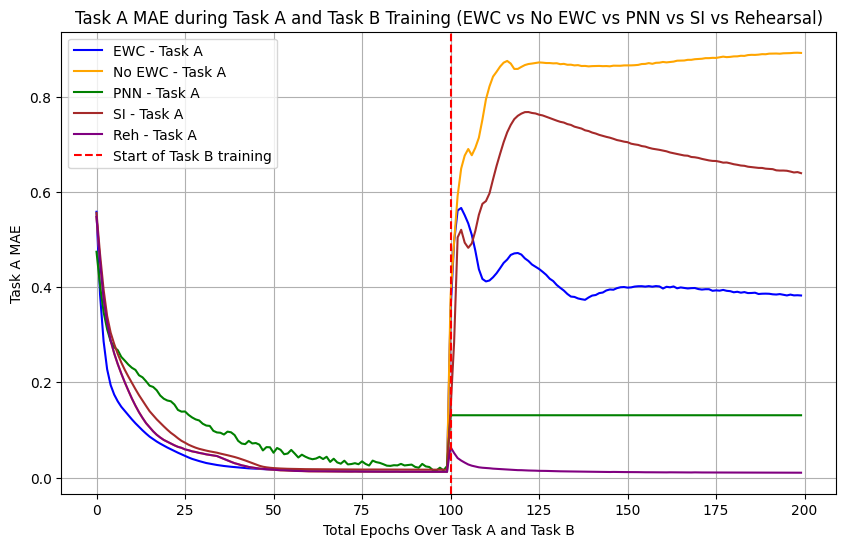

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats_A["Initial"]["accuracy"], axis=0)  # Mean across runs
no_ewc_initial_acc = np.mean(epoch_stats_no_ewc["ewc"]["A_during_A_val"], axis=0)
pnn_A_during_A = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0)
si_A_during_A = np.mean(epoch_stats_other_old["si"]["A_during_A_val"], axis=0)
reh_A_during_A = np.mean(epoch_stats_other["reh"]["A_during_A_val"], axis=0)

ewc_initial_acc = ewc_initial_acc[:100]
pnn_A_during_A = pnn_A_during_A[:100]
si_A_during_A = si_A_during_A[:100]
reh_A_during_A = reh_A_during_A[:100]

# Now for Task A accuracy during Task B training
ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)  # Average over runs
no_ewc_task_A_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_B"], axis=0)  # Same for No EWC
pnn_task_A_during_B = np.mean(epoch_stats_other["pnn"]["val_task_A_during_B"],axis = 0) # Same for pnn
si_task_A_during_B = np.mean(epoch_stats_other["si"]["val_task_A_during_B"], axis= 0) # Same for si
reh_task_A_during_B = np.mean(epoch_stats_other["reh"]["val_task_A_during_B"],axis = 0) # Same for reh

pnn_task_A_during_B = pnn_task_A_during_B[:100]
#si_task_A_during_B = si_task_A_during_B[:100]
reh_task_A_during_B = reh_task_A_during_B[:100]

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B])
pnn_task_A_combined = np.concatenate([pnn_A_during_A, pnn_task_A_during_B])
si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B])
reh_task_A_combined = np.concatenate([no_ewc_initial_acc, reh_task_A_during_B])

pnn_task_A_combined = pnn_task_A_combined[:200]
#si_task_A_combined = si_task_A_combined[:200]
#reh_task_A_combined = reh_task_A_combined[:100]

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Task A', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Task A', color='orange')
plt.plot(x_values, pnn_task_A_combined, label='PNN - Task A', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Task A', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Task A', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xlabel('Total Epochs Over Task A and Task B')
plt.ylabel('Task A MAE')
plt.title('Task A MAE during Task A and Task B Training (EWC vs No EWC vs PNN vs SI vs Rehearsal)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('til_toy_accuracy_taskA.png')
plt.show()


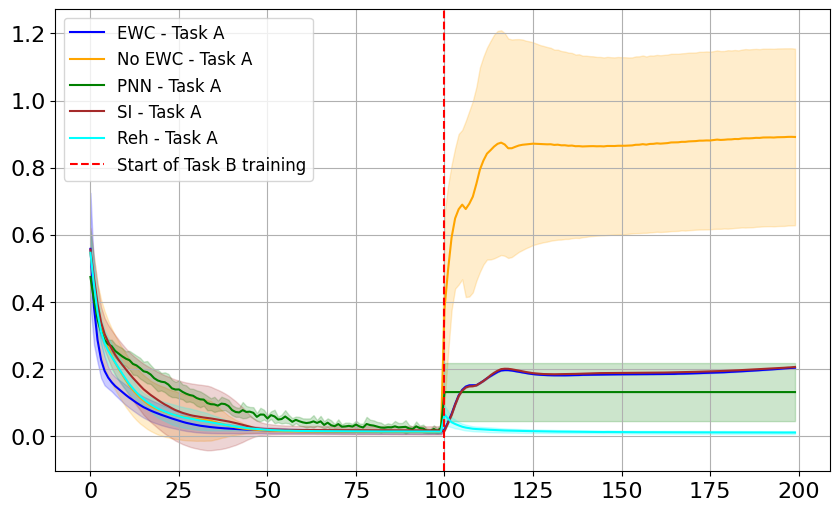

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation for Task A during Task A training
ewc_initial_acc = np.mean(epoch_stats_A["Initial"]["accuracy"], axis=0)
ewc_initial_acc_std = np.std(epoch_stats_A["Initial"]["accuracy"], axis=0)

no_ewc_initial_acc = np.mean(epoch_stats_no_ewc["ewc"]["A_during_A_val"], axis=0)
no_ewc_initial_acc_std = np.std(epoch_stats_no_ewc["ewc"]["A_during_A_val"], axis=0)

pnn_A_during_A = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0)
pnn_A_during_A_std = np.std(epoch_stats_other["pnn"]["A_during_A_val"], axis=0)

si_A_during_A = np.mean(epoch_stats_other_old["si"]["A_during_A_val"], axis=0)
si_A_during_A_std = np.std(epoch_stats_other_old["si"]["A_during_A_val"], axis=0)

reh_A_during_A = np.mean(epoch_stats_other["reh"]["A_during_A_val"], axis=0)
reh_A_during_A_std = np.std(epoch_stats_other["reh"]["A_during_A_val"], axis=0)

# Truncate arrays to 100 epochs for Task A training
ewc_initial_acc = ewc_initial_acc[:100]
ewc_initial_acc_std = ewc_initial_acc_std[:100]
pnn_A_during_A = pnn_A_during_A[:100]
pnn_A_during_A_std = pnn_A_during_A_std[:100]
si_A_during_A = si_A_during_A[:100]
si_A_during_A_std = si_A_during_A_std[:100]
reh_A_during_A = reh_A_during_A[:100]
reh_A_during_A_std = reh_A_during_A_std[:100]

# Calculate the mean and standard deviation for Task A during Task B training
ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)
ewc_task_A_during_B_std = np.std(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)

no_ewc_task_A_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_B"], axis=0)
no_ewc_task_A_during_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_B"], axis=0)

pnn_task_A_during_B = np.mean(epoch_stats_other["pnn"]["val_task_A_during_B"], axis=0)
pnn_task_A_during_B_std = np.std(epoch_stats_other["pnn"]["val_task_A_during_B"], axis=0)

si_task_A_during_B = np.mean(epoch_stats_other["si"]["val_task_A_during_B"], axis=0)
si_task_A_during_B_std = np.std(epoch_stats_other["si"]["val_task_A_during_B"], axis=0)

reh_task_A_during_B = np.mean(epoch_stats_other["reh"]["val_task_A_during_B"], axis=0)
reh_task_A_during_B_std = np.std(epoch_stats_other["reh"]["val_task_A_during_B"], axis=0)

# Truncate arrays to 100 epochs for Task B training
pnn_task_A_during_B = pnn_task_A_during_B[:100]
pnn_task_A_during_B_std = pnn_task_A_during_B_std[:100]
reh_task_A_during_B = reh_task_A_during_B[:100]
reh_task_A_during_B_std = reh_task_A_during_B_std[:100]

# Concatenate mean and std for Task A and Task B training
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B])
ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std])

no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std])

pnn_task_A_combined = np.concatenate([pnn_A_during_A, pnn_task_A_during_B])
pnn_task_A_combined_std = np.concatenate([pnn_A_during_A_std, pnn_task_A_during_B_std])

si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B])
si_task_A_combined_std = np.concatenate([si_A_during_A_std, si_task_A_during_B_std])

reh_task_A_combined = np.concatenate([reh_A_during_A, reh_task_A_during_B])
reh_task_A_combined_std = np.concatenate([reh_A_during_A_std, reh_task_A_during_B_std])

# Define x-axis
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

# Plot EWC with variance band
plt.plot(x_values, ewc_task_A_combined, label='EWC - Task A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - ewc_task_A_combined_std, ewc_task_A_combined + ewc_task_A_combined_std, color='blue', alpha=0.2)

# Plot No EWC with variance band
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Task A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined - no_ewc_task_A_combined_std, no_ewc_task_A_combined + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

# Plot PNN with variance band
plt.plot(x_values, pnn_task_A_combined, label='PNN - Task A', color='green')
plt.fill_between(x_values, pnn_task_A_combined - pnn_task_A_combined_std, pnn_task_A_combined + pnn_task_A_combined_std, color='green', alpha=0.2)

# Plot SI with variance band
plt.plot(x_values, si_task_A_combined, label='SI - Task A', color='brown')
plt.fill_between(x_values, si_task_A_combined - si_task_A_combined_std, si_task_A_combined + si_task_A_combined_std, color='brown', alpha=0.2)

# Plot Rehearsal with variance band
plt.plot(x_values, reh_task_A_combined, label='Reh - Task A', color='cyan')
plt.fill_between(x_values, reh_task_A_combined - reh_task_A_combined_std, reh_task_A_combined + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend


plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16)  
plt.legend(fontsize=12)
plt.grid(True)

# Save and show the plot
plt.savefig('til_toy_accuracy_taskA_with_variance_bigger.png')
plt.show()


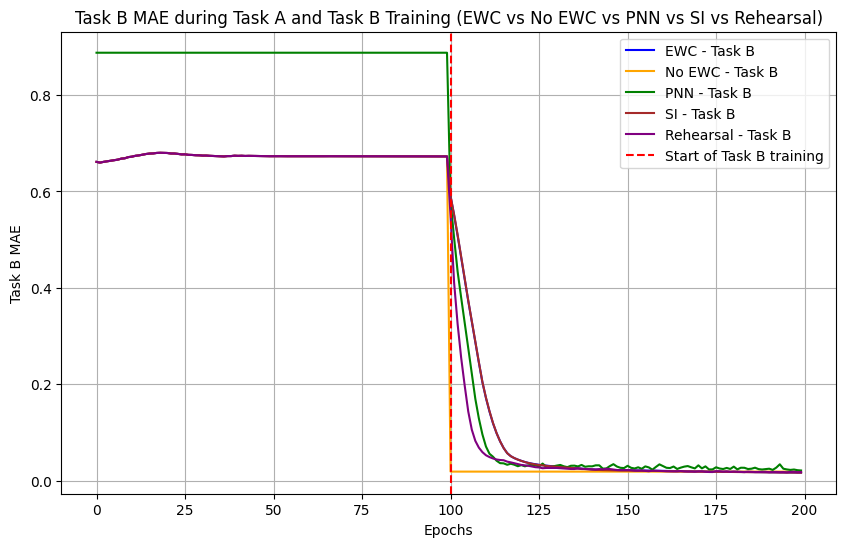

In [420]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean across runs for each method
task_B_ewc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Mean across runs for EWC
task_B_no_ewc = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)  # Mean across runs for No EWC
task_B_si = np.mean(epoch_stats_other["si"]["val_acc_B"], axis=0)  # Mean across runs for SI
task_B_reh = np.mean(epoch_stats_other["reh"]["val_acc_B"], axis=0)  # Mean across runs for Rehearsal
task_B_pnn = np.mean(epoch_stats_other["pnn"]["val_acc_B"], axis=0)  # Mean across runs for PNN

#task_B_si = task_B_si[:100]
task_B_pnn = task_B_pnn[:100]

# Compute the mean across runs for each method on Domain B during training on Domain A
task_B_during_A_ewc = np.mean(epoch_stats_no_ewc["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_no_ewc = np.mean(epoch_stats_no_ewc["ewc"]["B_during_A_val"], axis=0)
#task_B_during_A_si = np.mean(epoch_stats_other["si"]["B_during_A_val"], axis=0)
task_B_during_A_reh = np.mean(epoch_stats_other["reh"]["B_during_A_val"], axis=0)
task_B_during_A_pnn = np.mean(epoch_stats_other["pnn"]["B_during_A_val"], axis=0)

task_B_during_A_pnn = task_B_during_A_pnn[:100]

# Concatenate Task B accuracy for both phases: during Task A and during Task B training
ewc_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_ewc])
no_ewc_task_B_combined = np.concatenate([task_B_during_A_no_ewc, task_B_no_ewc])
pnn_task_B_combined = np.concatenate([task_B_during_A_pnn, task_B_pnn])
si_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_si])
reh_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_reh])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot MAE for each method
# Plot Domain B accuracy during training on Domain B for each method
plt.plot(x_values, ewc_task_B_combined, label='EWC - Task B', color='blue')
plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Task B', color='orange')
plt.plot(x_values, pnn_task_B_combined, label='PNN - Task B', color='green')
plt.plot(x_values, si_task_B_combined, label='SI - Task B', color='brown')
plt.plot(x_values, reh_task_B_combined, label='Rehearsal - Task B', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_ewc), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Task B MAE')
plt.title('Task B MAE during Task A and Task B Training (EWC vs No EWC vs PNN vs SI vs Rehearsal)')
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig('til_toy_task_B_during_A_and_B.png')
plt.show()


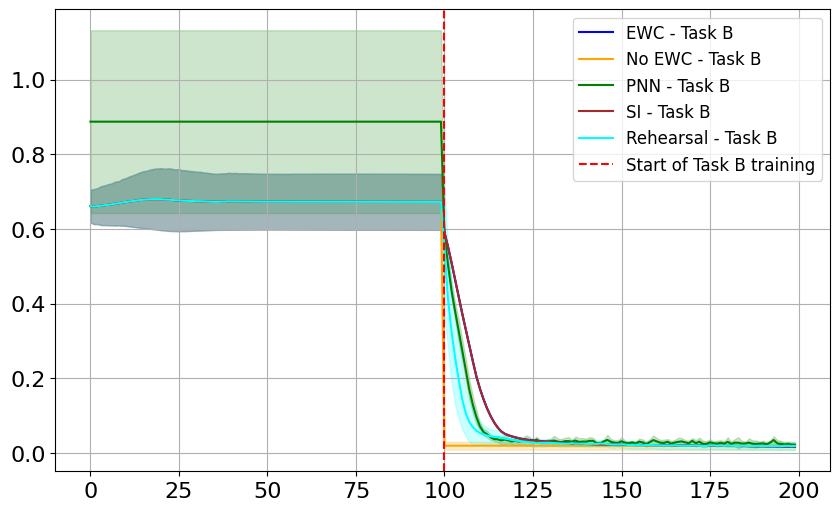

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean and standard deviation for Task B during Task B training
task_B_ewc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)
task_B_ewc_std = np.std(epoch_stats["ewc"]["val_task_B"], axis=0)

task_B_no_ewc = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)
task_B_no_ewc_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)

task_B_si = np.mean(epoch_stats_other["si"]["val_acc_B"], axis=0)
task_B_si_std = np.std(epoch_stats_other["si"]["val_acc_B"], axis=0)

task_B_reh = np.mean(epoch_stats_other["reh"]["val_acc_B"], axis=0)
task_B_reh_std = np.std(epoch_stats_other["reh"]["val_acc_B"], axis=0)

task_B_pnn = np.mean(epoch_stats_other["pnn"]["val_acc_B"], axis=0)
task_B_pnn_std = np.std(epoch_stats_other["pnn"]["val_acc_B"], axis=0)

# Truncate arrays for Task B training
task_B_pnn = task_B_pnn[:100]
task_B_pnn_std = task_B_pnn_std[:100]

# Compute the mean and standard deviation for Task B during Domain A training
task_B_during_A_ewc = np.mean(epoch_stats_no_ewc["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_ewc_std = np.std(epoch_stats_no_ewc["ewc"]["B_during_A_val"], axis=0)

task_B_during_A_no_ewc = np.mean(epoch_stats_no_ewc["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_no_ewc_std = np.std(epoch_stats_no_ewc["ewc"]["B_during_A_val"], axis=0)

task_B_during_A_reh = np.mean(epoch_stats_other["reh"]["B_during_A_val"], axis=0)
task_B_during_A_reh_std = np.std(epoch_stats_other["reh"]["B_during_A_val"], axis=0)

task_B_during_A_pnn = np.mean(epoch_stats_other["pnn"]["B_during_A_val"], axis=0)
task_B_during_A_pnn_std = np.std(epoch_stats_other["pnn"]["B_during_A_val"], axis=0)

# Truncate arrays for Domain A training
task_B_during_A_pnn = task_B_during_A_pnn[:100]
task_B_during_A_pnn_std = task_B_during_A_pnn_std[:100]

# Concatenate Task B accuracy and standard deviations for both phases
ewc_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_ewc])
ewc_task_B_combined_std = np.concatenate([task_B_during_A_ewc_std, task_B_ewc_std])

no_ewc_task_B_combined = np.concatenate([task_B_during_A_no_ewc, task_B_no_ewc])
no_ewc_task_B_combined_std = np.concatenate([task_B_during_A_no_ewc_std, task_B_no_ewc_std])

pnn_task_B_combined = np.concatenate([task_B_during_A_pnn, task_B_pnn])
pnn_task_B_combined_std = np.concatenate([task_B_during_A_pnn_std, task_B_pnn_std])

si_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_si])
si_task_B_combined_std = np.concatenate([task_B_during_A_ewc_std, task_B_si_std])

reh_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_reh])
reh_task_B_combined_std = np.concatenate([task_B_during_A_ewc_std, task_B_reh_std])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot with variance bands
plt.figure(figsize=(10, 6))

# Plot EWC with variance band
plt.plot(x_values, ewc_task_B_combined, label='EWC - Task B', color='blue')
plt.fill_between(x_values, ewc_task_B_combined - ewc_task_B_combined_std, ewc_task_B_combined + ewc_task_B_combined_std, color='blue', alpha=0.2)

# Plot No EWC with variance band
plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Task B', color='orange')
plt.fill_between(x_values, no_ewc_task_B_combined - no_ewc_task_B_combined_std, no_ewc_task_B_combined + no_ewc_task_B_combined_std, color='orange', alpha=0.2)

# Plot PNN with variance band
plt.plot(x_values, pnn_task_B_combined, label='PNN - Task B', color='green')
plt.fill_between(x_values, pnn_task_B_combined - pnn_task_B_combined_std, pnn_task_B_combined + pnn_task_B_combined_std, color='green', alpha=0.2)

# Plot SI with variance band
plt.plot(x_values, si_task_B_combined, label='SI - Task B', color='brown')
plt.fill_between(x_values, si_task_B_combined - si_task_B_combined_std, si_task_B_combined + si_task_B_combined_std, color='brown', alpha=0.2)

# Plot Rehearsal with variance band
plt.plot(x_values, reh_task_B_combined, label='Rehearsal - Task B', color='cyan')
plt.fill_between(x_values, reh_task_B_combined - reh_task_B_combined_std, reh_task_B_combined + reh_task_B_combined_std, color='cyan', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_during_A_ewc), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16)  
plt.legend(loc='upper right',fontsize=12)
plt.grid(True)

# Save and show the plot
plt.savefig('til_toy_task_B_during_A_and_B_with_variance_bigger.png')
plt.show()


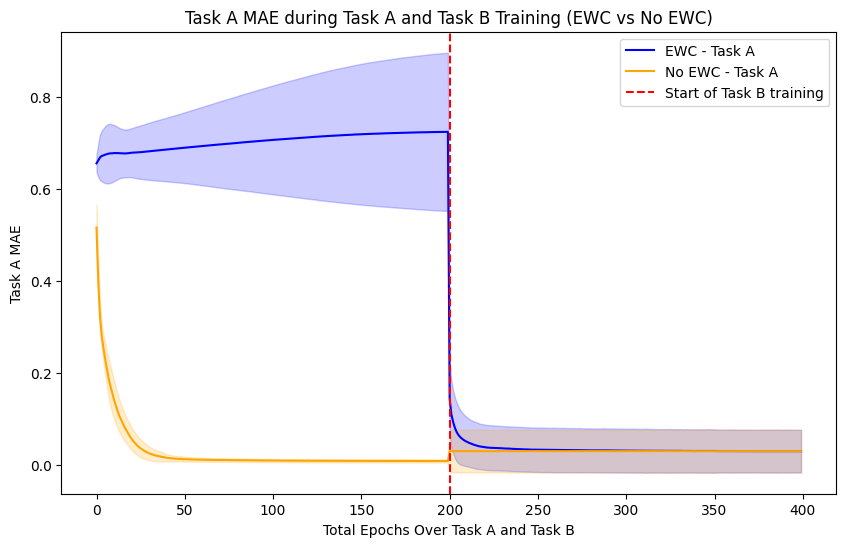

In [243]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for Task A during Task A and Task B across all runs
ewc_initial_acc_mean = np.mean(epoch_stats_B["Initial"]["accuracy"], axis=0)  # Mean across runs for EWC
ewc_initial_acc_std = np.std(epoch_stats_B["Initial"]["accuracy"], axis=0)    # Standard deviation for EWC

no_ewc_initial_acc_mean = np.mean(epoch_stats_A["Initial"]["accuracy"], axis=0)  # Mean for No EWC
no_ewc_initial_acc_std = np.std(epoch_stats_A["Initial"]["accuracy"], axis=0)    # Standard deviation for No EWC

# Calculate the mean and standard deviation for Task A during Task B training
ewc_task_A_during_B_mean = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Mean over runs for EWC
ewc_task_A_during_B_std = np.std(epoch_stats["ewc"]["val_task_B"], axis=0)    # Standard deviation for EWC

no_ewc_task_A_during_B_mean = np.mean(epoch_stats["no_ewc"]["val_task_B"], axis=0)  # Mean for No EWC
no_ewc_task_A_during_B_std = np.std(epoch_stats["no_ewc"]["val_task_B"], axis=0)    # Standard deviation for No EWC

# Concatenate the mean values for Task A accuracy during Task A and Task B phases
ewc_task_A_combined_mean = np.concatenate([ewc_initial_acc_mean, ewc_task_A_during_B_mean])
no_ewc_task_A_combined_mean = np.concatenate([no_ewc_initial_acc_mean, no_ewc_task_A_during_B_mean])

# Concatenate the standard deviations for Task A accuracy during Task A and Task B phases
ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined_mean)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))

# Plot EWC mean with standard deviation shading
plt.plot(x_values, ewc_task_A_combined_mean, label='EWC - Task A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined_mean - ewc_task_A_combined_std,
                 ewc_task_A_combined_mean + ewc_task_A_combined_std, color='blue', alpha=0.2)

# Plot No EWC mean with standard deviation shading
plt.plot(x_values, no_ewc_task_A_combined_mean, label='No EWC - Task A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined_mean - no_ewc_task_A_combined_std,
                 no_ewc_task_A_combined_mean + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc_mean), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xlabel('Total Epochs Over Task A and Task B')
plt.ylabel('Task A MAE')
plt.title('Task A MAE during Task A and Task B Training (EWC vs No EWC)')
plt.legend()

# Save and show the plot
#plt.savefig('til_toy_accuracy_taskA_variance.png')
plt.show()


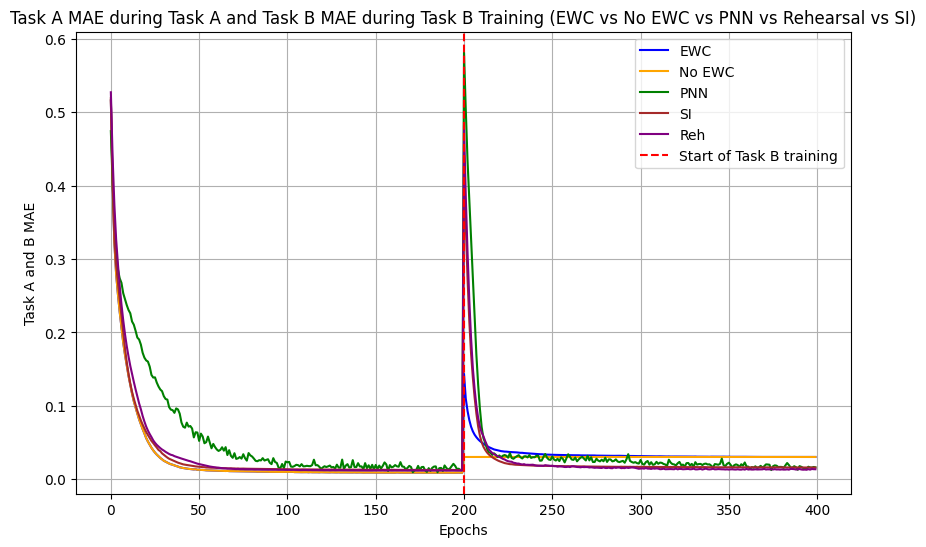

In [231]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats_A["Initial"]["accuracy"], axis=0)  # Mean across runs
no_ewc_initial_acc = np.mean(epoch_stats_A["Initial"]["accuracy"], axis=0)  # Same for No EWC
pnn_task_A_during_A = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0)
si_task_A_during_A = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0)
reh_task_A_during_A = np.mean(epoch_stats_other["reh"]["A_during_A_val"], axis=0)


task_B_ewc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Mean across runs for EWC
task_B_no_ewc = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)  # Mean across runs for No EWC
task_B_si = np.mean(epoch_stats_other["si"]["val_acc_B"], axis=0)  # Mean across runs for SI
task_B_reh = np.mean(epoch_stats_other["reh"]["val_acc_B"], axis=0)  # Mean across runs for Rehearsal
task_B_pnn = np.mean(epoch_stats_other["pnn"]["val_acc_B"], axis=0)  # Mean across runs for PNN


# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, task_B_ewc])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, task_B_no_ewc])
pnn_task_A_combined = np.concatenate([pnn_task_A_during_A, task_B_pnn])
si_task_A_combined = np.concatenate([si_task_A_during_A, task_B_si])
reh_task_A_combined = np.concatenate([reh_task_A_during_A, task_B_reh])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC', color='orange')
plt.plot(x_values, pnn_task_A_combined, label='PNN', color='green')
plt.plot(x_values, si_task_A_combined, label='SI', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Task B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Task A and B MAE')
plt.title('Task A MAE during Task A and Task B MAE during Task B Training (EWC vs No EWC vs PNN vs Rehearsal vs SI)')
plt.legend()
plt.grid(True)

# Save and show the plot
plt.savefig('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/TIL/Data/Toy/DIL_Toy_MAE_TaskA_and_TaskB.png')
plt.show()


In [46]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats_A["Initial"]["accuracy"])[:, -1])

# Extract final epoch statistics for Task A during Task B training
ewc_max_final, ewc_min_final, ewc_mean_final = calculate_final_epoch_stats_from_dict(epoch_stats["ewc"], "val_task_A_during_B")
no_ewc_max_final, no_ewc_min_final, no_ewc_mean_final = calculate_final_epoch_stats_from_dict(epoch_stats_no_ewc["no_ewc"], "val_task_A_during_B")
pnn_max_final, pnn_min_final, pnn_mean_final = calculate_final_epoch_stats_from_dict(epoch_stats_other["pnn"], "val_task_A_during_B")
si_max_final, si_min_final, si_mean_final = calculate_final_epoch_stats_from_dict(epoch_stats_other["si"], "val_task_A_during_B")
reh_max_final, reh_min_final, reh_mean_final = calculate_final_epoch_stats_from_dict(epoch_stats_other["reh"], "val_task_A_during_B")

# Create a summary table for Task A during Task B training
final_epoch_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "PNN", "SI", "Rehearsal"],
    "Max Final MAE": [ewc_max_final, no_ewc_max_final, pnn_max_final, si_max_final, reh_max_final],
    "Min Final MAE": [ewc_min_final, no_ewc_min_final, pnn_min_final, si_min_final, reh_min_final],
    "Mean Final MAE": [ewc_mean_final, no_ewc_mean_final, pnn_mean_final, si_mean_final, reh_mean_final]
})

# Extract the average final epoch MAE during Task A training for each method
avg_final_task_A_training = pd.DataFrame({
    "Method": ["EWC", "No EWC", "PNN", "SI", "Rehearsal"],
    "Avg Final Epoch MAE (Task A Training)": [
        avg_final_epoch_task_A_A,
        np.mean(np.array(epoch_stats_no_ewc["ewc"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_other["pnn"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_other_old["si"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_other["reh"]["A_during_A_val"])[:, -1])
    ]
})

# Helper function to calculate max, min, mean, and std for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_values = data[:, -1]  # Extract values from the last epoch
    
    max_final = np.max(final_epoch_values)  # Max of the final epoch
    min_final = np.min(final_epoch_values)  # Min of the final epoch
    mean_final = np.mean(final_epoch_values)  # Mean of the final epoch
    std_final = np.std(final_epoch_values)  # Standard deviation of the final epoch
    
    lower_bound = mean_final - 2 * std_final  # Mean - 2*STD
    upper_bound = mean_final + 2 * std_final  # Mean + 2*STD
    
    return max_final, min_final, mean_final, std_final, lower_bound, upper_bound

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats_A["Initial"]["accuracy"])[:, -1])

# Extract final epoch statistics for Task A during Task B training (including std and bounds)
ewc_max_final, ewc_min_final, ewc_mean_final, ewc_std_final, ewc_lower, ewc_upper = calculate_final_epoch_stats_from_dict(epoch_stats["ewc"], "val_task_A_during_B")
no_ewc_max_final, no_ewc_min_final, no_ewc_mean_final, no_ewc_std_final, no_ewc_lower, no_ewc_upper = calculate_final_epoch_stats_from_dict(epoch_stats_no_ewc["no_ewc"], "val_task_A_during_B")
pnn_max_final, pnn_min_final, pnn_mean_final, pnn_std_final, pnn_lower, pnn_upper = calculate_final_epoch_stats_from_dict(epoch_stats_other["pnn"], "val_task_A_during_B")
si_max_final, si_min_final, si_mean_final, si_std_final, si_lower, si_upper = calculate_final_epoch_stats_from_dict(epoch_stats_other["si"], "val_task_A_during_B")
reh_max_final, reh_min_final, reh_mean_final, reh_std_final, reh_lower, reh_upper = calculate_final_epoch_stats_from_dict(epoch_stats_other["reh"], "val_task_A_during_B")

# Create a summary table for Task A during Task B training with upper/lower bounds
final_epoch_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "PNN", "SI", "Rehearsal"],
    "Max Final MAE": [ewc_max_final, no_ewc_max_final, pnn_max_final, si_max_final, reh_max_final],
    "Min Final MAE": [ewc_min_final, no_ewc_min_final, pnn_min_final, si_min_final, reh_min_final],
    "Mean Final MAE": [ewc_mean_final, no_ewc_mean_final, pnn_mean_final, si_mean_final, reh_mean_final],
    "STD Final MAE": [ewc_std_final, no_ewc_std_final, pnn_std_final, si_std_final, reh_std_final],
    "Lower Bound (Mean - 2*STD)": [ewc_lower, no_ewc_lower, pnn_lower, si_lower, reh_lower],
    "Upper Bound (Mean + 2*STD)": [ewc_upper, no_ewc_upper, pnn_upper, si_upper, reh_upper]
})

# Extract the average final epoch MAE during Task A training for each method
avg_final_task_A_training = pd.DataFrame({
    "Method": ["EWC", "No EWC", "PNN", "SI", "Rehearsal"],
    "Avg Final Epoch MAE (Task A Training)": [
        avg_final_epoch_task_A_A,
        np.mean(np.array(epoch_stats_no_ewc["ewc"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_other["pnn"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_other_old["si"]["A_during_A_val"])[:, -1]),
        np.mean(np.array(epoch_stats_other["reh"]["A_during_A_val"])[:, -1])
    ]
})


# Display results
# Display results using print for both tables
print("Final Epoch Summary for Task A During Task B")
print(final_epoch_summary)

print("\nAvg Final Epoch MAE During Task A Training")
print(avg_final_task_A_training)



Final Epoch Summary for Task A During Task B
      Method  Max Final MAE  Min Final MAE  Mean Final MAE  STD Final MAE  \
0        EWC       0.205163       0.202256        0.203859       0.000899   
1     No EWC       1.284128       0.472704        0.891465       0.263286   
2        PNN       0.297887       0.038914        0.130995       0.086563   
3         SI       0.206904       0.204591        0.205815       0.000661   
4  Rehearsal       0.017279       0.005278        0.010394       0.004127   

   Lower Bound (Mean - 2*STD)  Upper Bound (Mean + 2*STD)  
0                    0.202061                    0.205657  
1                    0.364894                    1.418037  
2                   -0.042131                    0.304121  
3                    0.204493                    0.207138  
4                    0.002139                    0.018648  

Avg Final Epoch MAE During Task A Training
      Method  Avg Final Epoch MAE (Task A Training)
0        EWC                        

In [47]:
# Calculate statistics for the final epoch of Task B during Task B training

# Helper function to calculate mean, max, min, std, and bounds for the final epoch
def calculate_final_epoch_stats_task_B(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_values = data[:, -1]  # Extract values from the last epoch

    mean_final = np.mean(final_epoch_values)  # Mean of the final epoch
    max_final = np.max(final_epoch_values)  # Max of the final epoch
    min_final = np.min(final_epoch_values)  # Min of the final epoch
    std_final = np.std(final_epoch_values)  # Standard deviation of the final epoch

    lower_bound = mean_final - 2 * std_final  # Mean - 2*STD
    upper_bound = mean_final + 2 * std_final  # Mean + 2*STD

    return mean_final, max_final, min_final, std_final, lower_bound, upper_bound

# Calculate stats for each method (including std and bounds)
task_B_ewc_mean, task_B_ewc_max, task_B_ewc_min, task_B_ewc_std, task_B_ewc_lower, task_B_ewc_upper = calculate_final_epoch_stats_task_B(epoch_stats["ewc"], "val_task_B")
task_B_no_ewc_mean, task_B_no_ewc_max, task_B_no_ewc_min, task_B_no_ewc_std, task_B_no_ewc_lower, task_B_no_ewc_upper = calculate_final_epoch_stats_task_B(epoch_stats_no_ewc["no_ewc"], "val_task_B")
task_B_si_mean, task_B_si_max, task_B_si_min, task_B_si_std, task_B_si_lower, task_B_si_upper = calculate_final_epoch_stats_task_B(epoch_stats_other["si"], "val_acc_B")
task_B_reh_mean, task_B_reh_max, task_B_reh_min, task_B_reh_std, task_B_reh_lower, task_B_reh_upper = calculate_final_epoch_stats_task_B(epoch_stats_other["reh"], "val_acc_B")
task_B_pnn_mean, task_B_pnn_max, task_B_pnn_min, task_B_pnn_std, task_B_pnn_lower, task_B_pnn_upper = calculate_final_epoch_stats_task_B(epoch_stats_other["pnn"], "val_acc_B")

# Create a summary table for Task B during Task B training with upper/lower bounds
final_epoch_task_B_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "PNN", "SI", "Rehearsal"],
    "Mean Final MAE": [task_B_ewc_mean, task_B_no_ewc_mean, task_B_pnn_mean, task_B_si_mean, task_B_reh_mean],
    "Max Final MAE": [task_B_ewc_max, task_B_no_ewc_max, task_B_pnn_max, task_B_si_max, task_B_reh_max],
    "Min Final MAE": [task_B_ewc_min, task_B_no_ewc_min, task_B_pnn_min, task_B_si_min, task_B_reh_min],
    "STD Final MAE": [task_B_ewc_std, task_B_no_ewc_std, task_B_pnn_std, task_B_si_std, task_B_reh_std],
    "Lower Bound (Mean - 2*STD)": [task_B_ewc_lower, task_B_no_ewc_lower, task_B_pnn_lower, task_B_si_lower, task_B_reh_lower],
    "Upper Bound (Mean + 2*STD)": [task_B_ewc_upper, task_B_no_ewc_upper, task_B_pnn_upper, task_B_si_upper, task_B_reh_upper]
})


# Display results for Task B
print("Final Epoch Summary for Task B During Task B Training")
print(final_epoch_task_B_summary)


Final Epoch Summary for Task B During Task B Training
      Method  Mean Final MAE  Max Final MAE  Min Final MAE  STD Final MAE  \
0        EWC        0.017011       0.017130       0.016902       0.000058   
1     No EWC        0.019119       0.038426       0.007288       0.010707   
2        PNN        0.016360       0.028732       0.006416       0.007323   
3         SI        0.016798       0.016942       0.016614       0.000094   
4  Rehearsal        0.018378       0.032179       0.004283       0.010577   

   Lower Bound (Mean - 2*STD)  Upper Bound (Mean + 2*STD)  
0                    0.016895                    0.017127  
1                   -0.002294                    0.040533  
2                    0.001714                    0.031005  
3                    0.016610                    0.016986  
4                   -0.002776                    0.039532  
